# 2.0 Combine Data from ```prop.csv```

Data has now been filtered for the parcel numbers in the existing dataset. The end goal is to have a dataset with one row for each parcel in which to build the model. **Imputation will occur in a separate notebook!**

However, we can't forget to explore the existing data for trends or insight along the way, as well as engineer features as we see fit.

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

%matplotlib inline
sns.set_context('notebook')

In [73]:
path = '/'.join(os.getcwd().split('/')[:-1])
print path

/Volumes/Dropbox-1/largetransfer/luc/carter


In [74]:
tci = pd.read_csv(path+'/data/inspection_data/full_tci_survey_prelim.csv')

In [75]:
tci.columns 

Index([u'Parcel ID', u'Date', u'USE_CLASS', u'Ward', u'Label', u'SPA_NAME',
       u'Address', u'Survey Category', u'Survey Result', u'Open Vacant',
       u'For Sale or Rent', u'Apparent Property Use',
       u'Apparent Property Capacity', u'House Number Visible/Premises ID',
       u'Boarded Windows or Doors', u'Broken Windows', u'Roof Damage',
       u'Chimney Damage', u'Paint or Siding Damage',
       u'Gutters or Downspout Damage', u'Porch Damage', u'Garage Damage',
       u'Dumping (Trash/Debris)', u'Sidewalk Condition', u'Street Tree',
       u'Notes', u'Image', u'ppn', u'vacant'],
      dtype='object')

In [76]:
cols = ['Parcel ID','ppn','vacant','Date','Survey Category','Survey Result']
tci = tci[cols]

In [77]:
tci.head()

,Parcel ID,ppn,vacant,Date,Survey Category,Survey Result
0,00105901X,001-05-901X,-1,5/27/15,Not Surveyed,No Grade
1,00132003B,001-32-003B,-1,5/27/15,Not Surveyed,No Grade
2,00133014X,001-33-014X,-1,5/27/15,Not Surveyed,No Grade
3,00135901X,001-35-901X,1,10/2/15,Vacant Structure,C
4,00311043A,003-11-043A,-1,5/27/15,Not Surveyed,No Grade


## Clean and merge data from property characteristics

In [78]:
prop = pd.read_csv(path+'/data/clean_data/main_prop_filtered.csv')
prop = prop.drop_duplicates()

In [79]:
prop.shape

(158653, 65)

### Zip code

In [80]:
def filter_zip(x):
    try:
        x = str(int(float(x)))
    except ValueError:
        pass
    if len(x) == 5:
        return x
    else:
        return np.nan

In [81]:
prop['zip'] = prop['zip'].dropna().apply(filter_zip)
zips = set(prop['zip'].dropna())
# zips.difference_update(['.','0','4','441041'])
prop_zips = prop[['parcel','zip']][prop['zip'].isin(zips)].groupby('parcel').first()

In [82]:
tci = pd.merge(tci, prop_zips, how='left', left_on='ppn', right_index=True)
print tci.shape

(158855, 7)


### Property size

In [83]:
set(prop['propsize'].apply(type))

{float, str}

In [84]:
def parse_comma(x):
    if type(x) == str:
        x = int(x.replace(',',''))
    elif type(x) == float:
        if not np.isnan(x):
            x = int(x)
        else:
            pass
    else:
        pass
    return x

prop['propsize'] = prop['propsize'].apply(parse_comma)
parcel_size = prop[prop['propsize'].notnull()][['parcel','propsize']]\
                .sort('propsize', ascending=False).groupby('parcel').first()

# tci = pd.merge(tci, parcel_size, how='left', left_on='ppn', right_index=True)

In [85]:
def reject_outliers(data, m=1):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [86]:
max(reject_outliers(parcel_size[parcel_size.notnull()].propsize))

170749.0

In [87]:
np.mean(parcel_size[parcel_size.notnull()].propsize)

7600.3179712194915

In [88]:
np.linspace(200,10000)

array([   200.,    400.,    600.,    800.,   1000.,   1200.,   1400.,
         1600.,   1800.,   2000.,   2200.,   2400.,   2600.,   2800.,
         3000.,   3200.,   3400.,   3600.,   3800.,   4000.,   4200.,
         4400.,   4600.,   4800.,   5000.,   5200.,   5400.,   5600.,
         5800.,   6000.,   6200.,   6400.,   6600.,   6800.,   7000.,
         7200.,   7400.,   7600.,   7800.,   8000.,   8200.,   8400.,
         8600.,   8800.,   9000.,   9200.,   9400.,   9600.,   9800.,
        10000.])

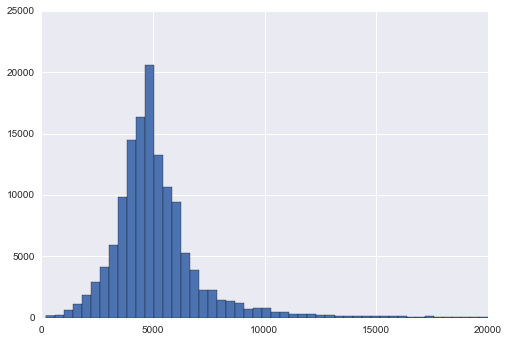

In [89]:
plt.hist(parcel_size[parcel_size.notnull()].propsize, bins=np.linspace(200,20000));

### pclass

We're only using residential parcels!

In [90]:
pclass = prop[prop['pclass'].notnull()][['parcel','pclass']].groupby('parcel').first()
tci = pd.merge(tci, pclass, how='left', left_on='ppn', right_index=True)

# filter non residential parcels
tci = tci[tci.pclass=="Residential"]

### Total usable area

In [91]:
prop['totusabl'] = prop['totusabl'].apply(parse_comma)
usable_area = prop[prop['totusabl'].notnull()][['parcel','totusabl']].sort('totusabl', ascending=False).groupby('parcel').first()
tci = pd.merge(tci, usable_area, how='left', left_on='ppn', right_index=True)

### Total market value

In [92]:
tmktval = prop[['tmktval','parcel']].groupby('parcel').median()
tci = pd.merge(tci, tmktval, how='left', left_on='ppn', right_index=True)
print tci.shape

(122560, 10)


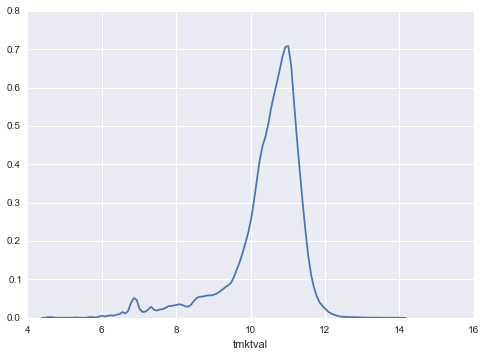

In [93]:
sns.distplot(tci.tmktval.apply(np.log))

### Condition

In [94]:
set(prop['condition'])

{nan,
 'Average',
 'Excellent',
 'Fair',
 'Good',
 'Poor',
 'Sound value (c)',
 'Unsound',
 'Very good',
 'Very poor'}

In [95]:
tci = pd.merge(tci, prop[['parcel','condition']].groupby('parcel').first(), how='left', left_on='ppn', right_index=True)

In [96]:
tci.shape

(122560, 11)

In [97]:
# unsound
# very poor
# poor
# fair
# average
# good
# very good
# sound
# excellent

condition_value = {'Unsound': 0, 'Very poor': 1, 'Poor': 2, 'Fair': 3, 'Average': 4, \
                   'Good': 5, 'Very good': 6, 'Sound value (c)': 7, 'Excellent': 8}
prop.loc[prop['condition'].notnull(),'condition_value'] = prop.loc[prop['condition'].notnull(),'condition'].apply(lambda x: condition_value[x])
tci = pd.merge(tci, prop[['parcel','condition_value']] \
               , how='left', left_on='ppn', right_on='parcel')
print tci.shape

(122560, 13)


In [98]:
sum(tci.loc[tci.vacant > -1,'vacant']), len(tci.loc[tci.vacant > -1,'vacant'])

(9760, 111150)

In [99]:
9760.0/111150

0.08780926675663518

In [100]:
t = tci.loc[tci.vacant > -1,['vacant','condition_value']].groupby('condition_value').agg([sum,len])
t.vacant['sum']/t.vacant['len']

condition_value
0    0.799632
1    0.452974
2    0.302351
3    0.130505
4    0.046860
5    0.032554
6    0.009238
8    0.018519
dtype: float64

### Housing style

In [101]:
prop.groupby('style').count()

,parcel,taxyr,pclass,nluc,luc,zip,owner,propsize,front,depth,...,inhis,diffval,_TYPE_,_FREQ_,chg_tval,PROP,LATITUDE,LONGITUDE,yearkey,condition_value
style,,,,,,,,,,,,,,,,,,,,,
3FM,1,1,1,1,1,1,1,1,1,0,...,1,0,0,0,1,1,1,1,1,1
Bi level,90,90,90,90,90,90,90,85,88,86,...,90,0,0,0,90,90,90,90,90,90
Bungalow,5078,5078,5078,5078,5078,5075,5078,5041,5058,5029,...,5078,4,0,0,5078,5078,5077,5077,5078,5078
Cape Cod,27699,27699,27699,27699,27699,27699,27698,27610,27657,27620,...,27699,49,0,0,27699,27699,27698,27698,27699,27699
Colonial,69498,69498,69498,69498,69498,69482,69498,68608,69306,68644,...,69498,151,0,0,69498,69498,69485,69485,69498,69498
Contemporary,130,130,130,130,130,130,130,122,130,126,...,130,0,0,0,130,130,130,130,130,130
DUP,7,7,7,7,7,7,7,6,7,7,...,7,1,0,0,7,7,7,7,7,7
Garden,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,1,1,1,1,1,1
Other,15,15,15,15,15,15,15,8,15,11,...,15,0,0,0,15,15,15,15,15,15


In [102]:
styles = ['Bungalow','Cape Cod','Colonial','Ranch','Townhouse']

def get_style(x):
    if x in styles:
        return x
    else:
        return np.nan

prop['style_filtered'] = prop['style'].apply(get_style)

In [103]:
tci = pd.merge(tci, prop[['parcel','style_filtered']] \
               , how='left', left_on='ppn', right_on='parcel')
print tci.shape

(122560, 15)


In [104]:
tci.loc[tci.style_filtered.isnull(),'style_filtered'] = 'Other'

In [105]:
tci.loc[tci.vacant>-1,['vacant','style_filtered']].groupby('style_filtered').agg([sum,len])

vacant       
                  sum    len
style_filtered              
Bungalow          360   4857
Cape Cod         1787  26986
Colonial         6983  66593
Other              98   1232
Ranch             511  10783
Townhouse          21    699

### Owner occupancy

In [106]:
def get_own(x):
    if x == 'Yes':
        return 1
    elif x == 'No':
        return 0
    else:
        return np.nan
    
prop['ownerocc_value'] = prop['ownerocc'].apply(get_own)

In [107]:
tci = pd.merge(tci, prop[['parcel','ownerocc_value']], \
               how='left', left_on='ppn', right_on='parcel')

In [108]:
tci.shape

(122560, 17)

In [109]:
t = tci.loc[tci.vacant>-1,['ownerocc_value','vacant']].groupby('ownerocc_value').agg([len, sum])
t.vacant['sum']/t.vacant['len']

ownerocc_value
0    0.142738
1    0.060106
dtype: float64

### Total buildings

In [110]:
tci = pd.merge(tci, prop[['parcel','totbldgs']], \
               how='left', left_on='ppn', right_on='parcel')
print tci.shape

(122560, 19)


### Year built

In [111]:
def get_year(x):
    try:
        x = int(x)
    except ValueError:
        x = np.nan
    return x

In [112]:
prop['yrbuilt_filtered'] = prop['yrbuilt'].apply(get_year)

In [113]:
tci = pd.merge(tci, prop[['parcel','yrbuilt_filtered']], \
               how='left', left_on='ppn', right_on='parcel')
tci.shape

(122560, 21)

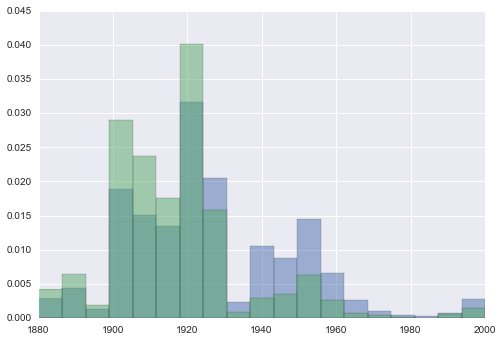

In [114]:
plt.hist(tci[(tci.vacant==0) & (tci.yrbuilt_filtered.notnull())].yrbuilt_filtered.values, bins=np.linspace(1880,2000,20),normed=True,alpha=0.5);
plt.hist(tci[(tci.vacant==1) & (tci.yrbuilt_filtered.notnull())].yrbuilt_filtered.values, bins=np.linspace(1880,2000,20),normed=True,alpha=0.5);

### Exterior Wall

In [115]:
prop.groupby('rextwall').count()

,parcel,taxyr,pclass,nluc,luc,zip,owner,propsize,front,depth,...,_FREQ_,chg_tval,PROP,LATITUDE,LONGITUDE,yearkey,condition_value,style_filtered,ownerocc_value,yrbuilt_filtered
rextwall,,,,,,,,,,,,,,,,,,,,,
Aluminum/Vinyl (r),72099,72099,72099,72099,72099,72084,72098,71325,71935,71485,...,0,72099,72099,71933,71933,72099,72099,71502,72099,72099
Asbestos Shingle (r),2350,2350,2350,2350,2350,2350,2350,2344,2347,2337,...,0,2350,2350,2350,2350,2350,2350,2349,2350,2350
Brick,10777,10777,10777,10777,10777,10776,10777,10672,10744,10665,...,0,10777,10777,10775,10775,10777,10777,10743,10777,10777
Brick/Stucco (r),88,88,88,88,88,88,88,85,88,85,...,0,88,88,88,88,88,88,88,88,88
Composite siding (r),564,564,564,564,564,561,564,550,561,559,...,0,564,564,552,552,564,564,560,564,564
Concrete block,98,98,98,98,98,98,98,97,98,97,...,0,98,98,98,98,98,98,97,98,98
Frame (r),27523,27523,27523,27523,27523,27515,27523,27266,27431,27200,...,0,27523,27523,27514,27514,27523,27523,27373,27523,27522
Frame/Brick (r),934,934,934,934,934,934,934,906,927,907,...,0,934,934,934,934,934,934,921,934,934
Other (r),44,44,44,44,44,44,44,44,44,42,...,0,44,44,40,40,44,44,42,44,44


In [116]:
tci = pd.merge(tci, prop[['parcel','rextwall']], \
               how='left', left_on='ppn', right_on='parcel')
print tci.shape

(122560, 23)


In [117]:
tci.rextwall = tci.rextwall.apply(lambda x: x if x in ['Aluminum/Vinyl (r)','Brick','Frame (r)','Asbestos Shingle (r)'] else 'Other')

## Add demographic variables

In [118]:
dem = pd.read_csv(path+'/data/clean_data/demographic.csv')

In [119]:
new_cols = ['parcel', 'vacant_block','owner','renter', 'median_rent','property_crimes','burglaries','other_drug', 'part_one_crimes','part_two_crimes', \
'bachelors+','poverty_rate','median_hh_income', 'median_fam_income','white','black','asian','other','hispanic','young','middle','old']

In [120]:
dem.columns = new_cols

In [121]:
use_cols = ['parcel', 'vacant_block', 'median_rent','property_crimes','burglaries', 'part_one_crimes','part_two_crimes', \
'bachelors+','poverty_rate','median_hh_income','white','black','asian','other','hispanic','young','middle','old']

In [ ]:
dem

In [137]:
dem.dtypes[dem.dtypes=='object']

parcel               object
vacant_block         object
median_rent          object
bachelors+           object
poverty_rate         object
median_hh_income     object
median_fam_income    object
white                object
black                object
asian                object
other                object
hispanic             object
young                object
middle               object
old                  object
dtype: object

In [138]:
for col in dem.dtypes[dem.dtypes=='object'].index[1:]:
    print col, len(dem.loc[dem[col]=='null', col])
    dem.loc[dem[col]=='null', col] = np.nan
    dem.loc[dem[col].notnull(), col] = dem.loc[dem[col].notnull(), col].apply(float)

vacant_block 0
median_rent 0
bachelors+ 0
poverty_rate 0
median_hh_income 0
median_fam_income 0
white 0
black 0
asian 0
other 0
hispanic 0
young 0
middle 0
old 0


In [123]:
tci = pd.merge(tci, dem[new_cols], left_on='ppn',right_on='parcel', how='left')

In [124]:
tci[tci['median_rent'].isnull()].shape

(216, 45)

In [125]:
tci.to_csv(path+'/data/model_data/tci_2_0.csv', index=False)

In [126]:
tci.shape

(122560, 45)